<a href="https://colab.research.google.com/github/matsu641/GCI_final_project/blob/main/GCI%E6%9C%80%E7%B5%82%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive をマウント
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")


# ライブラリをインポート
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# CSVファイルのパスを指定
file_path = '/content/drive/MyDrive/Colab Notebooks/GCI/FinalProject/ICompany/data.csv '
df = pd.read_csv(file_path)

Mounted at /content/drive


**離職率と各項目の相関関係**

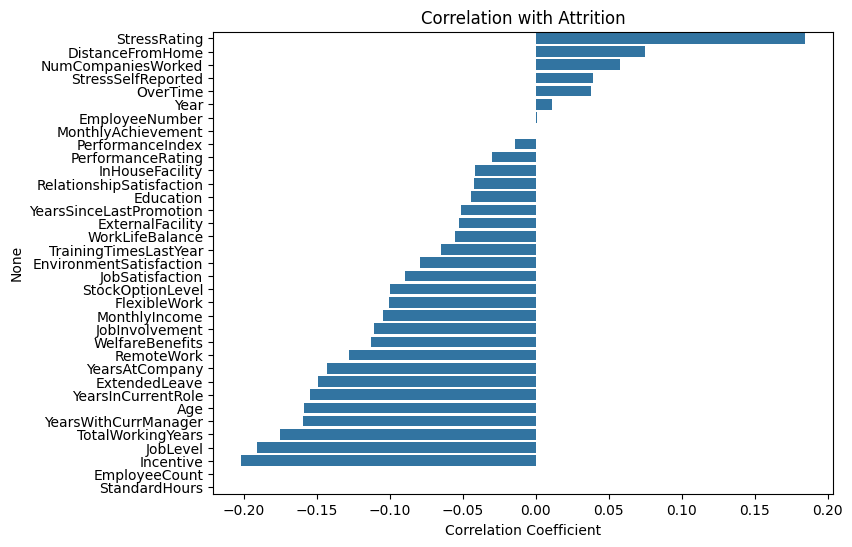

In [ ]:
# Attritionを数値化（Yes=1, No=0）
df['Attrition_num'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# 分離：カテゴリ変数と数値変数（AttritionとID列は除外）
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.drop('Attrition')
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Attrition_num')

# 相関（数値項目のみ）
corr = df[numeric_cols.tolist() + ['Attrition_num']].corr()['Attrition_num'].sort_values(ascending=False)

# 相関上位の数値項目をプロット
plt.figure(figsize=(8, 6))
sns.barplot(x=corr.drop('Attrition_num'), y=corr.drop('Attrition_num').index)
plt.title('Correlation with Attrition')
plt.xlabel('Correlation Coefficient')
plt.show()

**年代別離職率**

/tmp/ipython-input-3-470502193.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_by_bin = df.groupby("YearsBin")["Attrition_num"].mean().reset_index()


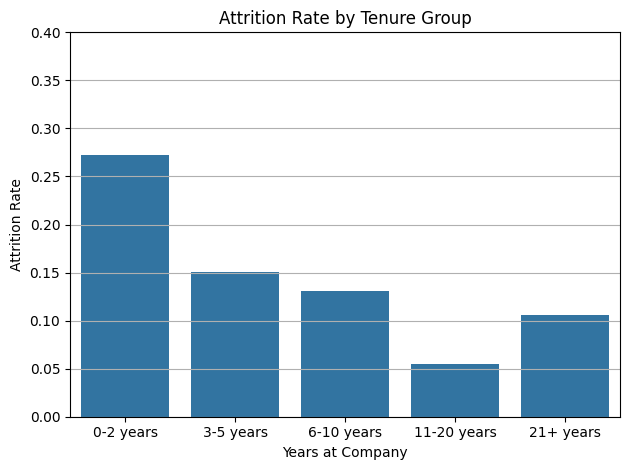

In [ ]:
# ビン分けのラベル
df["YearsBin"] = pd.cut(df["YearsAtCompany"],
                        bins=[0, 2, 5, 10, 20, 40],
                        labels=["0-2 years", "3-5 years", "6-10 years", "11-20 years", "21+ years"])

# 区分ごとの離職率を計算
attrition_by_bin = df.groupby("YearsBin")["Attrition_num"].mean().reset_index()

# 可視化
sns.barplot(data=attrition_by_bin, x="YearsBin", y="Attrition_num")
plt.title("Attrition Rate by Tenure Group")
plt.ylabel("Attrition Rate")
plt.xlabel("Years at Company")
plt.ylim(0, 0.4)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Attritionを数値化していない場合は念のため
df['Attrition_num'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# 全体の離職者数
total_attrition_count = df['Attrition_num'].sum()

# 入社5年以内で辞めた社員の離職者数
early_attrition_count = df[df['YearsAtCompany'] <= 5]['Attrition_num'].sum()

# 割合（全離職者のうち、5年以内に辞めた人の割合）
early_attrition_ratio = early_attrition_count / total_attrition_count * 100

print(f"全体の離職者数: {total_attrition_count}人")
print(f"入社5年以内の離職者数: {early_attrition_count}人")
print(f"全離職者に占める割合: {early_attrition_ratio:.1f}%")


全体の離職者数: 238人
入社5年以内の離職者数: 162人
全離職者に占める割合: 68.1%


**研修制度を受けた回数と離職率の関係**

Text(0.5, 1.0, 'Training Frequency vs Attrition (proxy for training system quality)')

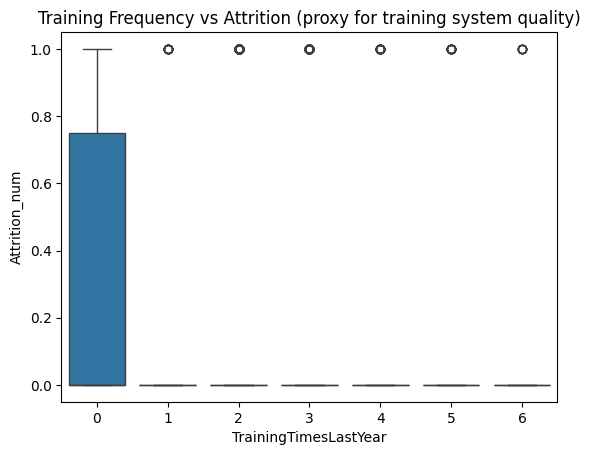

In [ ]:
sns.boxplot(x='TrainingTimesLastYear', y='Attrition_num', data=df)
plt.title('Training Frequency vs Attrition (proxy for training system quality)')


In [ ]:
df.groupby('TrainingTimesLastYear')['Attrition_num'].agg(['count','mean'])

,count,mean
TrainingTimesLastYear,,
0,54,0.259259
1,71,0.154930
2,547,0.182815
3,491,0.140530
4,123,0.186992
5,119,0.126050
6,65,0.092308


**離職率予想モデル**

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 130, number of negative: 488
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1196
[LightGBM] [Info] Number of data points in the train set: 618, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

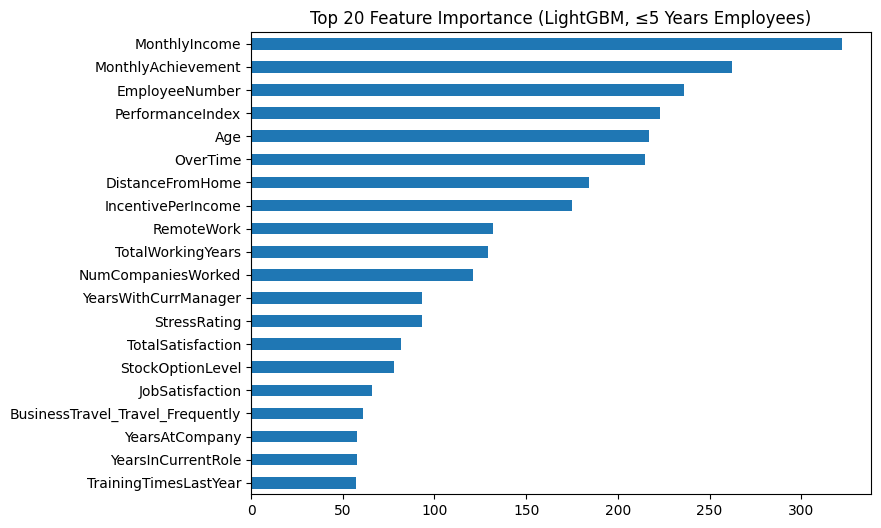

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# ================================
# ① データ前処理 & 特徴量エンジニアリング
# ================================

# Attritionを数値化
df['Attrition_num'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# 入社5年以内にフィルタリング
df_new = df[df['YearsAtCompany'] <= 5].copy()

# 新しい特徴量
df_new['IncentivePerIncome'] = df_new['Incentive'] / (df_new['MonthlyIncome'] + 1)
df_new['TotalSatisfaction'] = (
    df_new['JobSatisfaction'] + df_new['JobInvolvement'] + df_new['WorkLifeBalance']
) / 3

# カテゴリ変数をOne-Hotエンコード
df_encoded = pd.get_dummies(
    df_new.drop(columns=['Attrition', 'Attrition_num']), drop_first=True
)

# ================================
# ② 学習データ準備
# ================================
X = df_encoded
y = df_new['Attrition_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================================
# ③ ハイパーパラメータチューニング
# ================================
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}

search = RandomizedSearchCV(
    lgb.LGBMClassifier(
        objective='binary',
        class_weight='balanced',  # 不均衡データ対応
        random_state=42
    ),
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)
model = search.best_estimator_
print("Best Params:", search.best_params_)

# ================================
# ④ 閾値最適化（Precision-Recall Curveベース）
# ================================
y_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_thresh = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold: {optimal_thresh:.3f}")

y_pred = (y_proba >= optimal_thresh).astype(int)

# ================================
# ⑤ モデル評価
# ================================
print("Classification Report")
print(classification_report(y_test, y_pred))

# ================================
# ⑥ 重要特徴量の可視化
# ================================
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
importances.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance (LightGBM, ≤5 Years Employees)")
plt.show()


In [ ]:
# 全新人データ（2年以内）に対するAttrition確率算出
df_new['Attrition_risk'] = model.predict_proba(X)[:, 1]  # クラス1（離職）の確率

# リスクが高い順に並べる
high_risk_employees = df_new.sort_values('Attrition_risk', ascending=False)

# 上位10%（または任意のしきい値）を抽出
threshold = high_risk_employees['Attrition_risk'].quantile(0.9)  # 上位10%
high_risk_group = high_risk_employees[high_risk_employees['Attrition_risk'] >= threshold]

print("High Risk New Employees (Top 10%)")
print(high_risk_group[['EmployeeNumber', 'Attrition_risk']].head(20))


High Risk New Employees (Top 10%)
      EmployeeNumber  Attrition_risk
457              614        0.994479
357              478        0.993127
1021            1439        0.993068
1365            1928        0.993012
1068            1504        0.992608
1379            1944        0.990828
14                19        0.987646
421              565        0.987517
777             1079        0.987041
1060            1494        0.986420
42                55        0.986406
463              622        0.986088
480              648        0.986052
688              959        0.984818
683              952        0.982306
1438            2023        0.980588
952             1331        0.979965
140              190        0.979380
296              405        0.979094
204              282        0.978966


AUC: 0.946


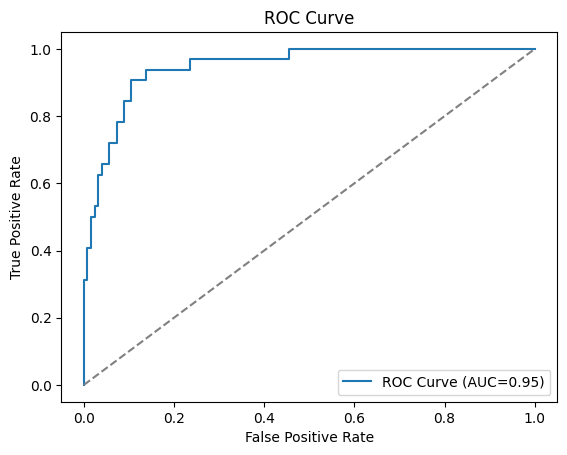

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# AUCスコア
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.3f}")

# ROC曲線（スライド用に可視化）
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={auc:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
print("df_newの人数:", len(df_new))

df_newの人数: 773
